#### Imports

In [2]:
import cv2
from pathlib import Path
from omegaconf import OmegaConf
import torch
import numpy as np
import wandb
from hydra import initialize, compose
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import wandb
from datetime import datetime
import matplotlib.pyplot as plt 



### Se toman las 4 carpetas (cable, capsule, screw y transistor) y se separa su información de testing training y se juntan en un solo dataset, igualmente guardando las etiquetas y se setea el tamaño de cada imagen en 128x128 como se indica en el documento

In [5]:
# Configuración
DATASETS = ['cable', 'capsule', 'screw', 'transistor']
BASE_PATH = Path('../TareaAutoEncoders')
OUTPUT_PATH = BASE_PATH / 'DATASET_128x128'
IMAGE_SIZE = (128, 128)

# Crear estructura de salida (carpetas planas)
for split in ['train', 'test', 'ground_truth']:
    (OUTPUT_PATH / split).mkdir(parents=True, exist_ok=True)

def process_and_save(src_path: Path, dest_dir: Path, prefix: str, is_mask=False):
    """Lee, redimensiona y guarda. Si is_mask usa INTER_NEAREST."""
    try:
        img = cv2.imread(str(src_path), cv2.IMREAD_UNCHANGED)
        if img is None:
            print(f"⚠️ No se pudo leer: {src_path}")
            return False
        interp = cv2.INTER_NEAREST if is_mask else cv2.INTER_AREA
        resized = cv2.resize(img, IMAGE_SIZE, interpolation=interp)
        dest = dest_dir / f"{prefix}_{src_path.stem}{src_path.suffix}"
        cv2.imwrite(str(dest), resized)
        return True
    except Exception as e:
        print(f"Error con {src_path}: {e}")
        return False

# Procesar datasets
for dataset in DATASETS:
    base = BASE_PATH / dataset

    # train -> normalmente sólo 'good' en estos datasets
    train_dir = base / 'train'
    if train_dir.exists():
        for cls in train_dir.iterdir():
            if not cls.is_dir(): 
                continue
            for img in cls.glob('*.*'):
                prefix = f"{dataset}_train_{cls.name}"
                process_and_save(img, OUTPUT_PATH / 'train', prefix, is_mask=False)

    # test -> incluir good y defectos
    test_dir = base / 'test'
    if test_dir.exists():
        for cls in test_dir.iterdir():
            if not cls.is_dir():
                continue
            for img in cls.glob('*.*'):
                prefix = f"{dataset}_test_{cls.name}"
                process_and_save(img, OUTPUT_PATH / 'test', prefix, is_mask=False)

    # ground_truth -> máscaras (usar nearest)
    gt_dir = base / 'ground_truth'
    if gt_dir.exists():
        for cls in gt_dir.iterdir():
            if not cls.is_dir():
                continue
            for img in cls.glob('*.*'):
                prefix = f"{dataset}_gt_{cls.name}"
                process_and_save(img, OUTPUT_PATH / 'ground_truth', prefix, is_mask=True)


## Configuración de los archivos Hydra

In [6]:
# Crear estructura base
conf_path = Path("conf")
conf_path.mkdir(exist_ok=True)

print("Directorio conf/ creado")

Directorio conf/ creado


In [7]:
# Celda 2: Crear carpetas necesarias
subdirs = ["model", "trainer", "logger", "loss", "optimizer"]
for subdir in subdirs:
    (conf_path / subdir).mkdir(exist_ok=True)

print("✅ Subdirectorios creados:")
for subdir in subdirs:
    print(f"   - conf/{subdir}/")

✅ Subdirectorios creados:
   - conf/model/
   - conf/trainer/
   - conf/logger/
   - conf/loss/
   - conf/optimizer/


In [8]:
# Celda: Crear variaciones de configuración para experimentos
# Variación 1: Latent dim pequeño
latent_small_yaml = """name: autoencoder_latent_small
in_channels: 3
hidden_dims: [32, 64, 128, 256]
latent_dim: 128
use_batch_norm: true
dropout_rate: 0.0
"""

with open("conf/model/autoencoder_latent_small.yaml", "w") as f:
    f.write(latent_small_yaml)

# Variación 2: Latent dim grande
latent_large_yaml = """name: autoencoder_latent_large
in_channels: 3
hidden_dims: [32, 64, 128, 256]
latent_dim: 1024
use_batch_norm: true
dropout_rate: 0.0
"""

with open("conf/model/autoencoder_latent_large.yaml", "w") as f:
    f.write(latent_large_yaml)

print("Variaciones de modelo creadas:")
print("   - autoencoder_latent_small (128)")
print("   - autoencoder_latent_large (1024)")

Variaciones de modelo creadas:
   - autoencoder_latent_small (128)
   - autoencoder_latent_large (1024)


In [17]:
# Celda 3: Crear conf/config.yaml (configuración principal)
config_yaml = """defaults:
  - model: autoencoder
  - trainer: default
  - logger: wandb
  - loss: l2
  - optimizer: adam_mid

seed: 42

data:
  data_dir: 'DATASET_128x128'
  image_size: 128
  batch_size: 32
  num_workers: 0
  validation_split: 0.15
  test_split: 0.15

callbacks:
  monitor: "val/loss"
  mode: "min"
  filename: "{epoch:02d}-{val/loss:.4f}"
  save_top_k: 3

experiment:
  name: "default_experiment"
  description: "Default autoencoder experiment"
"""

with open("conf/config.yaml", "w") as f:
    f.write(config_yaml)

print("conf/config.yaml creado")

conf/config.yaml creado


In [10]:
# Celda 4: Crear modelos - conf/model/autoencoder.yaml
autoencoder_yaml = """name: autoencoder
in_channels: 3
hidden_dims: [32, 64, 128, 256]
latent_dim: 512
use_batch_norm: true
dropout_rate: 0.0
"""

with open("conf/model/autoencoder.yaml", "w") as f:
    f.write(autoencoder_yaml)

print("conf/model/autoencoder.yaml creado")

conf/model/autoencoder.yaml creado


In [11]:
# Celda 5: Crear modelos - conf/model/unet.yaml
unet_yaml = """name: unet
in_channels: 3
base_channels: 32
depth: 4
use_batch_norm: true
dropout_rate: 0.0
"""

with open("conf/model/unet.yaml", "w") as f:
    f.write(unet_yaml)

print("conf/model/unet.yaml creado")

conf/model/unet.yaml creado


In [12]:
# Celda 6: Variaciones de autoencoder con latent_dim pequeño
autoencoder_small_yaml = """name: autoencoder_small
in_channels: 3
hidden_dims: [32, 64, 128]
latent_dim: 128
use_batch_norm: true
dropout_rate: 0.0
"""

with open("conf/model/autoencoder_small.yaml", "w") as f:
    f.write(autoencoder_small_yaml)

print("conf/model/autoencoder_small.yaml creado (latent_dim: 128)")

conf/model/autoencoder_small.yaml creado (latent_dim: 128)


In [13]:
# Celda 7: Variaciones de autoencoder con latent_dim grande
autoencoder_large_yaml = """name: autoencoder_large
in_channels: 3
hidden_dims: [32, 64, 128, 256, 512]
latent_dim: 1024
use_batch_norm: true
dropout_rate: 0.1
"""

with open("conf/model/autoencoder_large.yaml", "w") as f:
    f.write(autoencoder_large_yaml)

print("conf/model/autoencoder_large.yaml creado (latent_dim: 1024)")

conf/model/autoencoder_large.yaml creado (latent_dim: 1024)


In [14]:
# Celda 8: Funciones de pérdida - L1
l1_yaml = """name: l1
type: L1Loss
weight: 1.0
"""

with open("conf/loss/l1.yaml", "w") as f:
    f.write(l1_yaml)

print("conf/loss/l1.yaml creado")

conf/loss/l1.yaml creado


In [15]:
# Celda 9: Funciones de pérdida - L2 (MSE)
l2_yaml = """name: l2
type: MSELoss
weight: 1.0
"""

with open("conf/loss/l2.yaml", "w") as f:
    f.write(l2_yaml)

print("conf/loss/l2.yaml creado")

conf/loss/l2.yaml creado


In [16]:
# Celda 10: Funciones de pérdida - SSIM
ssim_yaml = """name: ssim
type: SSIMLoss
weight: 1.0
window_size: 11
sigma: 1.5
data_range: 1.0
"""

with open("conf/loss/ssim.yaml", "w") as f:
    f.write(ssim_yaml)

print("conf/loss/ssim.yaml creado")

conf/loss/ssim.yaml creado


In [17]:
# Celda 11: Funciones de pérdida - SSIM + L1
ssim_l1_yaml = """name: ssim_l1
type: SSIMLoss_L1
weight_ssim: 0.5
weight_l1: 0.5
window_size: 11
sigma: 1.5
data_range: 1.0
"""

with open("conf/loss/ssim_l1.yaml", "w") as f:
    f.write(ssim_l1_yaml)

print("conf/loss/ssim_l1.yaml creado")

conf/loss/ssim_l1.yaml creado


In [18]:
# Celda 12: Trainer - conf/trainer/default.yaml
trainer_yaml = """max_epochs: 20
gpus: 1
precision: 32
deterministic: true
check_val_every_n_epoch: 1
log_every_n_steps: 10
enable_model_summary: true
gradient_clip_val: 0.0
enable_progress_bar: true
"""

with open("conf/trainer/default.yaml", "w") as f:
    f.write(trainer_yaml)

print("conf/trainer/default.yaml creado")

conf/trainer/default.yaml creado


In [19]:
# Celda 13: Logger - conf/logger/wandb.yaml
wandb_yaml = """project: ae_experiments
entity: null
log_model: false
offline: false
tags: []
"""

with open("conf/logger/wandb.yaml", "w") as f:
    f.write(wandb_yaml)

print("conf/logger/wandb.yaml creado")

conf/logger/wandb.yaml creado


In [20]:
# Celda 14: Optimizer - Adam con LR bajo
adam_low_yaml = """name: adam_low
type: Adam
lr: 1e-4
weight_decay: 0.0
betas: [0.9, 0.999]
"""

with open("conf/optimizer/adam_low.yaml", "w") as f:
    f.write(adam_low_yaml)

print("conf/optimizer/adam_low.yaml creado (lr: 1e-4)")

conf/optimizer/adam_low.yaml creado (lr: 1e-4)


In [21]:
# Celda 15: Optimizer - Adam con LR medio
adam_mid_yaml = """name: adam_mid
type: Adam
lr: 1e-3
weight_decay: 0.0
betas: [0.9, 0.999]
"""

with open("conf/optimizer/adam_mid.yaml", "w") as f:
    f.write(adam_mid_yaml)

print("conf/optimizer/adam_mid.yaml creado (lr: 1e-3)")

conf/optimizer/adam_mid.yaml creado (lr: 1e-3)


In [22]:
# Celda 16: Optimizer - Adam con LR alto
adam_high_yaml = """name: adam_high
type: Adam
lr: 5e-3
weight_decay: 1e-5
betas: [0.9, 0.999]
"""

with open("conf/optimizer/adam_high.yaml", "w") as f:
    f.write(adam_high_yaml)

print("conf/optimizer/adam_high.yaml creado (lr: 5e-3)")

conf/optimizer/adam_high.yaml creado (lr: 5e-3)


## Definición del DataModule y modelo base (Autoencoder clásico con Hydra + PyTorch Lightning)


### Definición del Dataset para DATASET_128x128

En esta sección definimos una clase `MVTecDataset` basada en `torch.utils.data.Dataset`
que carga las imágenes ya preprocesadas a tamaño **128×128**.

Las imágenes se cargan en formato RGB y se convierten a tensores normalizados en \[0, 1].
Este dataset se utilizará dentro del `LightningDataModule` para separar train/val/test.


In [17]:
class MVTecDataset(Dataset):

    def __init__(self, root_dir, split="train", transform=None):
        super().__init__()
        self.root_dir = Path(root_dir)
        self.split = split
        self.transform = transform

        split_dir = self.root_dir / split
        exts = (".png", ".jpg", ".jpeg")

        self.image_paths = sorted(
            [p for p in split_dir.glob("*.*") if p.suffix.lower() in exts],
            key=lambda p: p.name
        )

        if len(self.image_paths) == 0:
            print(f"[WARNING] No se encontraron imágenes en {split_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        # Para autoencoder solo necesitamos la imagen (entrada = salida)
        return img


### LightningDataModule para MVTec

Para estructurar el flujo de datos usando PyTorch Lightning, se define un
`LightningDataModule` llamado `MVTecDataModule`.

Este módulo:

- Recibe los hiperparámetros desde la configuración (`cfg.data`):
  - `data_dir`, `batch_size`, `num_workers`, `validation_split`.
- Construye el `Dataset` de entrenamiento completo y lo separa en:
  - subconjunto de **train**
  - subconjunto de **validation** (usando `validation_split`).
- Crea el `Dataset` de **test**.
- Expone los `DataLoader`:
  - `train_dataloader()`
  - `val_dataloader()`
  - `test_dataloader()`

De esta forma, el mismo `DataModule` se reutiliza para todos los modelos y
experimentos (distintas funciones de pérdida, arquitecturas, etc.).


In [4]:
class MVTecDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir,
        batch_size=32,
        num_workers=2,
        val_split=0.15,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.val_split = val_split

        # Transformación básica: convertir a tensor en [0,1]
        self.transform = transforms.ToTensor()

    def setup(self, stage=None):
        # Dataset completo de entrenamiento (después se divide en train/val)
        full_train = MVTecDataset(
            root_dir=self.data_dir,
            split="train",
            transform=self.transform,
        )

        n_total = len(full_train)
        n_val = int(self.val_split * n_total)
        n_train = n_total - n_val

        self.train_set, self.val_set = torch.utils.data.random_split(
            full_train,
            [n_train, n_val],
            generator=torch.Generator().manual_seed(42),
        )

        # Dataset de test
        self.test_set = MVTecDataset(
            root_dir=self.data_dir,
            split="test",
            transform=self.transform,
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_set,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_set,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_set,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )


### Construcción de función de pérdida y optimizador desde Hydra

La configuración de la tarea se maneja con Hydra. En particular:

- `conf/loss/*.yaml` define el tipo de función de pérdida a usar
  (L1, L2, SSIM, SSIM + L1, etc.).
- `conf/optimizer/*.yaml` define el tipo de optimizador y sus hiperparámetros
  (por ejemplo, Adam con distintas tasas de aprendizaje).

Para desacoplar el modelo de estas decisiones, se implementan dos funciones:

- `build_loss(loss_cfg)`: a partir de `cfg.loss` devuelve un objeto de pérdida
  de PyTorch.
- `build_optimizer(optimizer_cfg, parameters)`: a partir de `cfg.optimizer`
  devuelve una instancia del optimizador apropiado.



In [5]:
def build_loss(loss_cfg):
    """
    Construye la función de pérdida a partir de cfg.loss.
    Por ahora se implementan L1 y L2 (MSE).
    """
    loss_type = loss_cfg.type

    if loss_type == "L1Loss":
        return nn.L1Loss()
    elif loss_type == "MSELoss":
        return nn.MSELoss()
    else:
        # Aquí luego se agregarán SSIM y SSIM+L1
        raise NotImplementedError(f"Pérdida '{loss_type}' aún no implementada en este notebook.")
    

def build_optimizer(optimizer_cfg, parameters):
    """
    Construye el optimizador a partir de cfg.optimizer.
    Actualmente soporta Adam con lr configurable.
    """
    opt_type = optimizer_cfg.type

    if opt_type == "Adam":
        return torch.optim.Adam(
            parameters,
            lr=optimizer_cfg.lr,
            weight_decay=optimizer_cfg.weight_decay,
            betas=tuple(optimizer_cfg.betas),
        )
    else:
        raise NotImplementedError(f"Optimizer '{opt_type}' no implementado.")


### Modelo base: Autoencoder clásico con PyTorch Lightning

En esta sección se define el modelo de **autoencoder clásico** como un
`LightningModule` llamado `LitAutoencoder`.

Este módulo:

- Lee su configuración desde `cfg.model`:
  - `in_channels`
  - `hidden_dims` (lista de canales intermedios)
  - `latent_dim`
- Construye un **encoder** convolucional que reduce la resolución de la imagen.
- Aplica capas totalmente conectadas para:
  - Proyectar la salida del encoder a un espacio latente de dimensión `latent_dim`.
  - Reconstruir desde el espacio latente a la forma intermedia del decoder.
- Construye un **decoder** con convoluciones transpuestas para recuperar
  una imagen de tamaño 128×128 y 3 canales.
- Utiliza la función de pérdida definida en `cfg.loss`.
- Utiliza el optimizador definido en `cfg.optimizer`.

Este modelo será el primero en usarse para los experimentos de la tarea
(con distintas funciones de pérdida). 


In [6]:
class LitAutoencoder(pl.LightningModule):
    def __init__(self, model_cfg, loss_cfg, optimizer_cfg, image_size=128):
        super().__init__()
        # Guardamos la config de modelo como hyperparams (para reproducibilidad)
        self.save_hyperparameters(OmegaConf.to_container(model_cfg, resolve=True))

        self.model_cfg = model_cfg
        self.loss_cfg = loss_cfg
        self.optimizer_cfg = optimizer_cfg
        self.image_size = image_size

        in_channels = model_cfg.in_channels
        hidden_dims = list(model_cfg.hidden_dims)
        latent_dim = model_cfg.latent_dim

        # Encoder: secuencia de convoluciones con stride 2
        modules = []
        channels = in_channels
        size = image_size
        for h in hidden_dims:
            modules.append(nn.Conv2d(channels, h, kernel_size=3, stride=2, padding=1))
            modules.append(nn.ReLU())
            channels = h
            size = size // 2  # cada conv con stride 2 reduce la mitad

        self.encoder = nn.Sequential(*modules)
        self.enc_out_channels = channels
        self.enc_out_size = size

        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(channels * size * size, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, channels * size * size)

        # Decoder: conv transpuestas para volver a 3x128x128
        modules = []
        hidden_dims_rev = list(hidden_dims[::-1])

        for i in range(len(hidden_dims_rev) - 1):
            modules.append(
                nn.ConvTranspose2d(
                    hidden_dims_rev[i],
                    hidden_dims_rev[i + 1],
                    kernel_size=4,
                    stride=2,
                    padding=1,
                )
            )
            modules.append(nn.ReLU())

        modules.append(
            nn.ConvTranspose2d(
                hidden_dims_rev[-1],
                in_channels,
                kernel_size=4,
                stride=2,
                padding=1,
            )
        )
        modules.append(nn.Sigmoid())  # salida en [0,1]

        self.decoder = nn.Sequential(*modules)

        # Pérdida
        self.criterion = build_loss(loss_cfg)

    def forward(self, x):
        x_enc = self.encoder(x)
        x_flat = self.flatten(x_enc)
        z = self.fc_mu(x_flat)
        x_dec_flat = self.fc_decode(z)
        x_dec = x_dec_flat.view(
            x.shape[0],
            self.enc_out_channels,
            self.enc_out_size,
            self.enc_out_size,
        )
        x_hat = self.decoder(x_dec)
        return x_hat

    def _shared_step(self, batch, stage):
        x = batch
        x_hat = self(x)
        loss = self.criterion(x_hat, x)
        self.log(f"{stage}_loss", loss, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, "val")

    def test_step(self, batch, batch_idx):
        self._shared_step(batch, "test")

    def configure_optimizers(self):
        optimizer = build_optimizer(self.optimizer_cfg, self.parameters())
        return optimizer


### Función principal de entrenamiento con Hydra y WandB

Finalmente, se define una función `train_autoencoder_with_hydra()` que
integra todos los componentes anteriores:

1. Inicializa Hydra y carga la configuración desde `conf/config.yaml`.
2. Construye el `MVTecDataModule` usando `cfg.data`.
3. Construye el `LitAutoencoder` usando:
   - `cfg.model` (arquitectura del autoencoder clásico),
   - `cfg.loss` (función de pérdida),
   - `cfg.optimizer` (optimizador).
4. Inicializa un `WandbLogger` con los parámetros de `cfg.logger`.
5. Crea un `Trainer` de PyTorch Lightning con los parámetros definidos en `cfg.trainer`.
6. Llama a `trainer.fit(model, datamodule=dm)` para entrenar el modelo.



In [7]:
def train_autoencoder_with_hydra():
    """
    Función de entrenamiento principal.
    Usa Hydra para cargar conf/config.yaml y los subarchivos.
    """
    with initialize(config_path="conf", version_base=None):
        cfg = compose(config_name="config")

    print("Configuración cargada:")
    print(OmegaConf.to_yaml(cfg))

    # DataModule
    dm = MVTecDataModule(
        data_dir=cfg.data.data_dir,
        batch_size=cfg.data.batch_size,
        num_workers=cfg.data.num_workers,
        val_split=cfg.data.validation_split,
    )

    # Modelo (autoencoder clásico)
    model = LitAutoencoder(
        model_cfg=cfg.model,
        loss_cfg=cfg.loss,
        optimizer_cfg=cfg.optimizer,
        image_size=cfg.data.image_size,
    )

    # Logger de WandB
    wandb_logger = WandbLogger(
        project=cfg.logger.project,
        entity=cfg.logger.entity,
        log_model=cfg.logger.log_model,
    )

    # Trainer a partir de cfg.trainer
    trainer = pl.Trainer(
        max_epochs=cfg.trainer.max_epochs,
        log_every_n_steps=cfg.trainer.log_every_n_steps,
        deterministic=cfg.trainer.deterministic,
        enable_model_summary=cfg.trainer.enable_model_summary,
        enable_progress_bar=cfg.trainer.enable_progress_bar,
        logger=wandb_logger,
    )

    trainer.fit(model, datamodule=dm)


### Configuraciones de funciones de pérdida (Hydra)

Se requiere evaluar distintas funciones de pérdida para el autoencoder:

- **L1**  
- **L2 (MSE)**  
- **SSIM**  
- **SSIM + L1**

Para permitir cambiar entre estas variantes desde Hydra sin modificar código,
se definen cuatro archivos de configuración en `conf/loss/`:

- `l1.yaml`
- `l2.yaml`
- `ssim.yaml`
- `ssim_l1.yaml`

Cada uno especifica el tipo de pérdida a usar (`type`) y, en el caso de SSIM,
algunos hiperparámetros adicionales.


In [8]:
Path("conf/loss").mkdir(parents=True, exist_ok=True)

l1_yaml = """type: L1Loss
name: "L1"
"""

l2_yaml = """type: MSELoss
name: "L2"
"""

ssim_yaml = """type: SSIM
name: "SSIM"
window_size: 11
sigma: 1.5
data_range: 1.0
"""

ssim_l1_yaml = """type: SSIM_L1
name: "SSIM+L1"
window_size: 11
sigma: 1.5
data_range: 1.0
l1_weight: 0.1
"""

with open("conf/loss/l1.yaml", "w") as f:
    f.write(l1_yaml)

with open("conf/loss/l2.yaml", "w") as f:
    f.write(l2_yaml)

with open("conf/loss/ssim.yaml", "w") as f:
    f.write(ssim_yaml)

with open("conf/loss/ssim_l1.yaml", "w") as f:
    f.write(ssim_l1_yaml)

print("Archivos de configuración de pérdidas creados/actualizados en conf/loss/")


Archivos de configuración de pérdidas creados/actualizados en conf/loss/


### Implementación de la pérdida SSIM

La métrica **Structural Similarity Index (SSIM)** mide la similitud estructural
entre dos imágenes. A diferencia de L1/L2, que comparan píxel a píxel,
SSIM toma en cuenta:

- luminancia,
- contraste,
- estructura local.

Para usar SSIM como pérdida, se suele minimizar `1 - SSIM(x, y)`, donde `x` es
la imagen original y `y` la reconstrucción del autoencoder.

A continuación se define una implementación en PyTorch que:

- Convierte la fórmula de SSIM a operaciones de convolución 2D con un kernel
  gaussiano.
- Calcula SSIM de forma local y luego promedia el resultado.
- Devuelve `1 - SSIM` como valor de pérdida.


In [9]:

class SSIMLoss(nn.Module):
    def __init__(
        self,
        window_size=11,
        sigma=1.5,
        data_range=1.0,
        channel=3,
        K1=0.01,
        K2=0.03,
    ):
        """
        Implementación de SSIM como pérdida: loss = 1 - SSIM.
        Asume imágenes en rango [0, data_range] y 3 canales por defecto.
        """
        super().__init__()
        self.window_size = window_size
        self.sigma = sigma
        self.data_range = data_range
        self.channel = channel
        self.K1 = K1
        self.K2 = K2

        self.register_buffer("window", self._create_window(window_size, sigma, channel))

    def _gaussian(self, window_size, sigma):
        gauss = torch.tensor(
            [
                (-(x - window_size // 2) ** 2) / float(2 * sigma**2)
                for x in range(window_size)
            ]
        )
        gauss = torch.exp(gauss)
        return gauss / gauss.sum()

    def _create_window(self, window_size, sigma, channel):
        _1d_window = self._gaussian(window_size, sigma).unsqueeze(1)
        _2d_window = _1d_window @ _1d_window.t()  # producto externo
        _2d_window = _2d_window.float().unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
        window = _2d_window.expand(channel, 1, window_size, window_size).contiguous()
        return window

    def forward(self, x, y):
        """
        x, y: tensores [B, C, H, W] en rango [0, data_range]
        Devuelve 1 - SSIM promedio en el batch.
        """
        if x.size(1) != self.channel or y.size(1) != self.channel:
            # Simplemente adaptamos el canal si es distinto (por si acaso)
            self.channel = x.size(1)
            self.window = self._create_window(self.window_size, self.sigma, self.channel).to(x.device)

        # Constantes de SSIM
        C1 = (self.K1 * self.data_range) ** 2
        C2 = (self.K2 * self.data_range) ** 2

        # Media local
        mu_x = torch.nn.functional.conv2d(
            x, self.window, padding=self.window_size // 2, groups=self.channel
        )
        mu_y = torch.nn.functional.conv2d(
            y, self.window, padding=self.window_size // 2, groups=self.channel
        )

        mu_x2 = mu_x * mu_x
        mu_y2 = mu_y * mu_y
        mu_xy = mu_x * mu_y

        # Varianzas y covarianza
        sigma_x2 = torch.nn.functional.conv2d(
            x * x, self.window, padding=self.window_size // 2, groups=self.channel
        ) - mu_x2
        sigma_y2 = torch.nn.functional.conv2d(
            y * y, self.window, padding=self.window_size // 2, groups=self.channel
        ) - mu_y2
        sigma_xy = torch.nn.functional.conv2d(
            x * y, self.window, padding=self.window_size // 2, groups=self.channel
        ) - mu_xy

        # Fórmula de SSIM
        num = (2 * mu_xy + C1) * (2 * sigma_xy + C2)
        den = (mu_x2 + mu_y2 + C1) * (sigma_x2 + sigma_y2 + C2)

        ssim_map = num / (den + 1e-8)
        ssim = ssim_map.mean()

        # Pérdida = 1 - SSIM promedio
        loss = 1 - ssim
        return loss


### Actualización de `build_loss` para incluir SSIM y SSIM+L1

Con la clase `SSIMLoss` definida, se extiende la función `build_loss` para
reconocer cuatro tipos de pérdida:

- `L1Loss`  → L1 estándar.
- `MSELoss` → L2 (MSE).
- `SSIM`    → `1 - SSIM(x, y)`.
- `SSIM_L1` → combinación lineal de SSIM y L1.


In [10]:
def build_loss(loss_cfg):
    """
    Construye la función de pérdida a partir de cfg.loss.

    Soporta:
      - L1Loss
      - MSELoss
      - SSIM
      - SSIM_L1 (combinación SSIM + L1)
    """
    loss_type = loss_cfg.type

    if loss_type == "L1Loss":
        return nn.L1Loss()

    elif loss_type == "MSELoss":
        return nn.MSELoss()

    elif loss_type == "SSIM":
        return SSIMLoss(
            window_size=loss_cfg.window_size,
            sigma=loss_cfg.sigma,
            data_range=loss_cfg.data_range,
            channel=3,  # nuestras imágenes son RGB
        )

    elif loss_type == "SSIM_L1":
        ssim_loss = SSIMLoss(
            window_size=loss_cfg.window_size,
            sigma=loss_cfg.sigma,
            data_range=loss_cfg.data_range,
            channel=3,
        )
        l1 = nn.L1Loss()
        l1_weight = loss_cfg.l1_weight

        class SSIML1Combined(nn.Module):
            def __init__(self, ssim_loss, l1, l1_weight):
                super().__init__()
                self.ssim_loss = ssim_loss
                self.l1 = l1
                self.l1_weight = l1_weight

            def forward(self, x, y):
                loss_ssim = self.ssim_loss(x, y)        # 1 - SSIM
                loss_l1 = self.l1(x, y)
                return loss_ssim + self.l1_weight * loss_l1

        return SSIML1Combined(ssim_loss, l1, l1_weight)

    else:
        raise NotImplementedError(f"Pérdida '{loss_type}' aún no implementada.")


### Configuración del modelo U-Net (Hydra)

Se requiere evaluar un autoencoder clásico y un autoencoder tipo **U-Net**.

Para permitir seleccionar esta arquitectura desde Hydra sin modificar el código,
se crea el archivo `conf/model/unet.yaml`, donde se definen sus parámetros:

- `in_channels`: número de canales de entrada (3 para RGB)
- `base_channels`: número inicial de filtros del encoder
- `depth`: cantidad de niveles de downsampling / upsampling
- `latent_dim`: tamaño del cuello (opcional)


In [11]:
Path("conf/model").mkdir(exist_ok=True)

unet_yaml = """in_channels: 3
base_channels: 32
depth: 4
latent_dim: 128
"""

with open("conf/model/unet.yaml", "w") as f:
    f.write(unet_yaml)

print("conf/model/unet.yaml creado")


conf/model/unet.yaml creado


### Implementación del Autoencoder U-Net

Este modelo sigue una estructura típica de U-Net:

1. **Encoder**:
   - Múltiples niveles de convoluciones + downsampling (stride 2).
   - Se almacenan características para las conexiones tipo "skip".

2. **Bottleneck**:
   - Capa completamente conectada para pasar al espacio latente.

3. **Decoder**:
   - ConvTransposed2D para upsampling simétrico.
   - Se concatenan los "skip connections" del encoder.

Este modelo debe:
- Usar la misma función de pérdida configurada en `cfg.loss`
- Usar el mismo optimizador configurado en `cfg.optimizer`
- Ser llamado desde Hydra con:
  `defaults: - model: unet`


In [20]:
class UNetEncoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.block(x)


class UNetDecoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        """
        in_ch: número de canales de entrada al bloque (antes del upsample)
        out_ch: número de canales de salida deseados después del bloque
        Este bloque realiza el upsample internamente (ConvTranspose2d) y luego
        procesa la concatenación con el skip connection.
        """
        super().__init__()
        # up transforma de in_ch -> out_ch (upsample)
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        # luego se concatena con skip (out_ch + skip_ch), asumimos skip_ch == out_ch
        self.block = nn.Sequential(
            nn.Conv2d(out_ch * 2, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.block(x)


class LitUNetAutoencoder(pl.LightningModule):
    def __init__(self, model_cfg, loss_cfg, optimizer_cfg):
        super().__init__()
        self.save_hyperparameters(OmegaConf.to_container(model_cfg, resolve=True))

        self.model_cfg = model_cfg
        self.loss_cfg = loss_cfg
        self.optimizer_cfg = optimizer_cfg

        base = model_cfg.base_channels
        depth = model_cfg.depth
        in_ch = model_cfg.in_channels

        # ----- Encoder -----
        self.enc_blocks = nn.ModuleList()
        self.downsamples = nn.ModuleList()
        ch = in_ch
        channels = []

        for d in range(depth):
            out_ch = base * (2 ** d)
            self.enc_blocks.append(UNetEncoderBlock(ch, out_ch))
            channels.append(out_ch)
            ch = out_ch
            self.downsamples.append(nn.Conv2d(out_ch, out_ch, kernel_size=2, stride=2))

        # Bottleneck
        self.bottleneck = UNetEncoderBlock(ch, ch * 2)

        # ----- Decoder -----
        # Nota: cada UNetDecoderBlock ya hace su propio upsampling internamente.
        # Guardamos los bloques decoders en orden inverso.
        self.dec_blocks = nn.ModuleList()
        ch = ch * 2  # canales salientes del bottleneck

        for d in reversed(range(depth)):
            out_ch = base * (2 ** d)
            # dec block espera in_ch = ch (canales actuales antes de up), out_ch = canales deseados después
            self.dec_blocks.append(UNetDecoderBlock(ch, out_ch))
            ch = out_ch

        # Output (3 canales)
        self.final_conv = nn.Conv2d(base, 3, kernel_size=1)
        self.activation = nn.Sigmoid()

        # Loss
        self.criterion = build_loss(loss_cfg)

    def forward(self, x):
        skips = []
        out = x

        # Encoder
        for enc, down in zip(self.enc_blocks, self.downsamples):
            out = enc(out)
            skips.append(out)
            out = down(out)

        # Bottleneck
        out = self.bottleneck(out)

        # Decoder
        # IMPORTANTE: aquí NO hacemos up(out) ni cat manualmente porque cada dec_block
        # hace el up + concat internamente. Solo llamamos a cada dec_block con (out, skip).
        for dec, skip in zip(self.dec_blocks, reversed(skips)):
            out = dec(out, skip)

        out = self.final_conv(out)
        return self.activation(out)

    def _shared_step(self, batch, stage):
        x = batch
        x_hat = self(x)
        loss = self.criterion(x_hat, x)
        self.log(f"{stage}_loss", loss, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self._shared_step(batch, "test")

    def configure_optimizers(self):
        return build_optimizer(self.optimizer_cfg, self.parameters())

### Función de entrenamiento para soportar Autoencoder y U-Net

Se reescribe la función `train_autoencoder_with_hydra()` para:

- Cargar la configuración completa desde Hydra.
- Crear automáticamente el DataModule.
- Instanciar el modelo según `cfg.model`:
  - `autoencoder` → `LitAutoencoder`
  - `unet` → `LitUNetAutoencoder`
- Inicializar WandB.
- Crear un Trainer de Lightning.
- Entrenar el modelo.



In [13]:
def train_autoencoder_with_hydra():
    """
    Versión actualizada: soporta modelos 'autoencoder' y 'unet'.
    Utiliza Hydra + Lightning + WandB para ejecutar entrenamientos reproducibles.
    """

    # 1. Cargar configuración completa desde Hydra
    with initialize(config_path="conf", version_base=None):
        cfg = compose(config_name="config")

    print("=========== CONFIGURACIÓN CARGADA ===========")
    print(OmegaConf.to_yaml(cfg))
    print("==============================================")

    # 2. Crear DataModule con los parámetros de cfg.data
    dm = MVTecDataModule(
        data_dir=cfg.data.data_dir,
        batch_size=cfg.data.batch_size,
        num_workers=cfg.data.num_workers,
        val_split=cfg.data.validation_split,
    )

    # 3. Instanciar modelo según cfg.model
    model_type = cfg.model._target_ if "_target_" in cfg.model else None

    # Detectar cuál modelo estamos usando
    if "unet" in cfg.model.__dict__['_content'] or "unet" in str(cfg.model):
        print("📌 Instanciando modelo: U-Net Autoencoder")
        model = LitUNetAutoencoder(
            model_cfg=cfg.model,
            loss_cfg=cfg.loss,
            optimizer_cfg=cfg.optimizer,
        )
    else:
        print("📌 Instanciando modelo: Autoencoder clásico")
        model = LitAutoencoder(
            model_cfg=cfg.model,
            loss_cfg=cfg.loss,
            optimizer_cfg=cfg.optimizer,
            image_size=cfg.data.image_size,
        )

    # 4. WandB Logger
    wandb_logger = WandbLogger(
        project=cfg.logger.project,
        entity=cfg.logger.entity,
        log_model=cfg.logger.log_model,
    )

    # 5. Trainer de Lightning con parámetros de Hydra
    trainer = pl.Trainer(
        max_epochs=cfg.trainer.max_epochs,
        log_every_n_steps=cfg.trainer.log_every_n_steps,
        deterministic=cfg.trainer.deterministic,
        enable_model_summary=cfg.trainer.enable_model_summary,
        enable_progress_bar=cfg.trainer.enable_progress_bar,
        logger=wandb_logger,
    )

    # 6. Entrenamiento
    trainer.fit(model, datamodule=dm)

    print("✨ Entrenamiento finalizado correctamente ✨")

    return model, dm, cfg


## Experimentación con WandB(Weight and Biases)

In [21]:
class LossPlotCallback(pl.Callback):
    """Callback para graficar train/val loss al final del entrenamiento"""
    
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
    
    def on_train_epoch_end(self, trainer, pl_module):
        """Guarda el train loss de cada epoch"""
        metrics = trainer.callback_metrics
        if 'train_loss' in metrics:
            try:
                self.train_losses.append(metrics['train_loss'].item())
            except Exception:
                self.train_losses.append(float(metrics['train_loss']))
    
    def on_validation_epoch_end(self, trainer, pl_module):
        """Guarda el val loss de cada epoch"""
        metrics = trainer.callback_metrics
        if 'val_loss' in metrics:
            try:
                self.val_losses.append(metrics['val_loss'].item())
            except Exception:
                self.val_losses.append(float(metrics['val_loss']))
    
    def on_fit_end(self, trainer, pl_module):
        """Grafica y loguea al final del entrenamiento"""
        if len(self.train_losses) == 0 or len(self.val_losses) == 0:
            return
        
        import matplotlib.pyplot as plt
        
        fig, ax = plt.subplots(figsize=(10, 6))
        epochs = range(1, len(self.train_losses) + 1)
        
        ax.plot(epochs, self.train_losses, label='Train Loss', marker='o', linewidth=2)
        ax.plot(epochs, self.val_losses, label='Val Loss', marker='s', linewidth=2)
        
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Loss', fontsize=12)
        ax.set_title('Training and Validation Loss', fontsize=14)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Loguear en WandB
        wandb.log({"loss_curve": wandb.Image(fig)})
        plt.close(fig)
        

class ImageReconstructionLogger(pl.Callback):
    """Callback para loguear reconstrucciones de imágenes (elige muestras diversas por dataset)."""

    def __init__(self, num_images=4):
        super().__init__()
        self.num_images = num_images
        self.logged_count = 0

    def on_validation_epoch_end(self, trainer, pl_module):
        try:
            # Intentar obtener directamente un batch rápido (por compatibilidad)
            val_loader = trainer.datamodule.val_dataloader()
            batch = next(iter(val_loader))

            if isinstance(batch, (list, tuple)):
                batch_data = batch[0]
            else:
                batch_data = batch

            # DEBUG: mostrar forma del batch
            try:
                print(f"📸 Batch shape: {getattr(batch_data, 'shape', None)}, necesito {self.num_images}")
            except Exception:
                pass

            # Intentar seleccionar muestras deterministas y diversas (una por dataset si es posible)
            try:
                val_subset = trainer.datamodule.val_set
                if val_subset is not None and hasattr(val_subset, "dataset"):
                    ds = val_subset.dataset  # MVTecDataset (full dataset antes del split)
                    indices = getattr(val_subset, "indices", None) or getattr(val_subset, "_indices", None)
                    if indices is not None and len(indices) > 0:
                        # Intentar escoger una muestra por cada dataset (cable, capsule, screw, transistor)
                        datasets_names = ['cable', 'capsule', 'screw', 'transistor']
                        chosen = []
                        seen = set()
                        for idx in indices:
                            name = ds.image_paths[idx].name.lower()
                            for d in datasets_names:
                                if d in name and d not in seen:
                                    chosen.append(idx)
                                    seen.add(d)
                                    break
                            if len(chosen) >= self.num_images:
                                break
                        # Si no conseguimos diversidad suficiente, usar los primeros índices del subset
                        if len(chosen) < self.num_images:
                            chosen = list(indices[: self.num_images])
                        sample_idx = chosen[: self.num_images]
                        sample_paths = [str(ds.image_paths[i]) for i in sample_idx]
                        print("🔎 Rutas de validación (muestras que se usarán):", sample_paths)

                        # Construir batch_data a partir de los paths seleccionados para evitar confusiones
                        batch_tensors = []
                        for p in sample_paths:
                            img = Image.open(p).convert("RGB")
                            if hasattr(ds, "transform") and ds.transform is not None:
                                t = ds.transform(img)
                            else:
                                t = transforms.ToTensor()(img)
                            batch_tensors.append(t.unsqueeze(0))
                        if len(batch_tensors) > 0:
                            batch_data = torch.cat(batch_tensors, dim=0).to(pl_module.device)
            except Exception as e:
                print(f"⚠️ Warning selection diversity failed: {e}")

            # Limitar a num_images (por si vino de val_loader)
            batch_data = batch_data[: self.num_images].to(pl_module.device)

            with torch.no_grad():
                reconstructed = pl_module(batch_data)

            # Pasar a CPU / numpy y crear visualización
            batch_cpu = batch_data.cpu()
            reconstructed_cpu = reconstructed.cpu()

            original_imgs = batch_cpu.numpy().transpose(0, 2, 3, 1)
            reconstructed_imgs = reconstructed_cpu.numpy().transpose(0, 2, 3, 1)

            images_to_log = []
            for i in range(len(original_imgs)):
                original = original_imgs[i]
                recon = reconstructed_imgs[i]
                combined = np.concatenate([original, recon], axis=1)
                combined = np.clip(combined, 0, 1)
                images_to_log.append(wandb.Image(combined, caption=f"Original vs Reconstructed {i}"))

            if len(images_to_log) > 0:
                self.logged_count += len(images_to_log)
                print(f"✅ Logueadas {len(images_to_log)} imágenes. Total: {self.logged_count}")
                wandb.log({"reconstructions": images_to_log}, step=trainer.global_step)

        except Exception as e:
            print(f"❌ Error en ImageReconstructionLogger: {type(e).__name__}: {e}")
            import traceback
            traceback.print_exc()


class LatentSpaceVisualizer(pl.Callback):
    """Callback para visualizar el espacio latente con PCA"""
    
    def __init__(self, num_images=100):
        super().__init__()
        self.num_images = num_images
    
    def on_validation_epoch_end(self, trainer, pl_module):
        """Visualiza el espacio latente cada N epochs"""
        if trainer.current_epoch % 5 != 0:
            return
        
        try:
            from sklearn.decomposition import PCA
            import matplotlib.pyplot as plt  # ← IMPORTAR AQUI TAMBIÉN
        except ImportError as e:
            print(f"⚠️ Error de importación: {e}")
            return
        
        val_loader = trainer.datamodule.val_dataloader()
        latent_vectors = []
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                if batch_idx * len(batch) >= self.num_images:
                    break
                
                batch = batch.to(pl_module.device)
                
                try:
                    if not hasattr(pl_module, 'encoder'):
                        return
                    
                    x_enc = pl_module.encoder(batch)
                    x_flat = pl_module.flatten(x_enc)
                    z = pl_module.fc_mu(x_flat)
                    latent_vectors.append(z.cpu().numpy())
                except AttributeError as e:
                    print(f"⚠️ Modelo incompatible: {e}")
                    return
        
        if len(latent_vectors) == 0:
            print("⚠️ No hay vectores latentes")
            return
        
        latent_vectors = np.concatenate(latent_vectors, axis=0)
        
        print(f"📊 Aplicando PCA a {len(latent_vectors)} muestras...")
        try:
            pca = PCA(n_components=2, random_state=42)
            latent_2d = pca.fit_transform(latent_vectors)
            
            fig = self._create_plot(latent_2d, pca)
            wandb.log({"latent_space": wandb.Image(fig)}, step=trainer.global_step)
            plt.close(fig)
            
        except Exception as e:
            print(f"⚠️ Error en PCA: {e}")
    
    @staticmethod
    def _create_plot(latent_2d, pca):
        """Crea figura con PCA"""
        import matplotlib.pyplot as plt
        
        fig, ax = plt.subplots(figsize=(10, 8))
        scatter = ax.scatter(
            latent_2d[:, 0], 
            latent_2d[:, 1], 
            c=range(len(latent_2d)), 
            cmap='viridis', 
            alpha=0.6, 
            s=50
        )
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
        ax.set_title('Latent Space Visualization (PCA)')
        plt.colorbar(scatter, ax=ax)
        plt.tight_layout()
        return fig


class AnomalyDetectionVisualizer(pl.Callback):
    """Callback para visualizar reconstrucciones de imágenes normales y anómalas"""
    
    def __init__(self, data_dir='DATASET_128x128', num_images=4):
        super().__init__()
        self.data_dir = data_dir
        self.num_images = num_images
        self.test_dataset = None
    
    def setup(self, trainer, pl_module, stage=None):
        """Configurar dataset de prueba"""
        if self.test_dataset is None:
            self.test_dataset = MVTecDataset(
                root_dir=self.data_dir,
                split='test',
                transform=transforms.ToTensor()
            )
    
    def on_validation_epoch_end(self, trainer, pl_module):
        """Visualiza reconstrucciones del set de prueba"""
        if trainer.current_epoch % 5 != 0:
            return
        
        if self.test_dataset is None or len(self.test_dataset) == 0:
            return
        
        try:
            # Obtener muestras aleatorias
            n_samples = min(self.num_images, len(self.test_dataset))
            indices = np.random.choice(len(self.test_dataset), n_samples, replace=False)
            test_images = []
            
            for idx in indices:
                test_images.append(self.test_dataset[idx])
            
            test_batch = torch.stack(test_images).to(pl_module.device)
            
            with torch.no_grad():
                reconstructed = pl_module(test_batch)
            
            # Calcular MSE
            mse = torch.mean((test_batch - reconstructed) ** 2, dim=[1, 2, 3])
            
            # Pasar a CPU
            test_batch_cpu = test_batch.cpu()
            reconstructed_cpu = reconstructed.cpu()
            
            # Convertir a numpy
            original_imgs = test_batch_cpu.numpy().transpose(0, 2, 3, 1)
            reconstructed_imgs = reconstructed_cpu.numpy().transpose(0, 2, 3, 1)
            error_maps = mse.cpu().numpy()
            
            # Crear visualizaciones
            images_to_log = []
            median_error = np.median(error_maps)
            
            for i in range(len(original_imgs)):
                original = original_imgs[i]
                recon = reconstructed_imgs[i]
                error = error_maps[i]
                
                # Normalizar error map a [0, 1]
                error_normalized = (error - error_maps.min()) / (error_maps.max() - error_maps.min() + 1e-8)
                error_map_3ch = np.stack([error_normalized] * 3, axis=-1)
                
                # Concatenar paneles
                combined = np.concatenate([original, recon, error_map_3ch], axis=1)
                combined = np.clip(combined, 0, 1)
                
                label = "Good" if error < median_error else "Anomaly"
                images_to_log.append(
                    wandb.Image(combined, caption=f"{label} - MSE: {error:.4f}")
                )
            
            if len(images_to_log) > 0:
                wandb.log({"test_reconstructions": images_to_log}, step=trainer.global_step)
                
        except Exception as e:
            print(f"⚠️ Error en AnomalyDetectionVisualizer: {e}")


def run_experiment(config_name, model_name, loss_name, optimizer_name, run_name):
    """
    Ejecuta un experimento con la configuración especificada
    
    Args:
        config_name: nombre de la configuración base (default: 'config')
        model_name: nombre del modelo en conf/model/
        loss_name: nombre de la función de pérdida en conf/loss/
        optimizer_name: nombre del optimizador en conf/optimizer/
        run_name: nombre del run en WandB
    """
    
    # ✅ VERIFICAR GPU DISPONIBLE
    if not torch.cuda.is_available():
        print("⚠️ WARNING: No hay GPU disponible. Se usará CPU.")
        device = "cpu"
    else:
        device = "cuda"
        print(f"✅ GPU detectada: {torch.cuda.get_device_name(0)}")
        print(f"   Memoria: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Inicializar WandB
    wandb.init(
        project="ae_experiments",
        name=run_name,
        config={
            "model": model_name,
            "loss": loss_name,
            "optimizer": optimizer_name,
            "device": device,  # ← LOGUEAR DEVICE
        }
    )
    
    try:
        # Cargar configuración con Hydra
        with initialize(config_path="conf", version_base=None):
            cfg = compose(
                config_name=config_name,
                overrides=[
                    f"model={model_name}",
                    f"loss={loss_name}",
                    f"optimizer={optimizer_name}",
                ]
            )
        
        print(f"\n{'='*60}")
        print(f"Ejecutando experimento: {run_name}")
        print(f"{'='*60}")
        print(OmegaConf.to_yaml(cfg))
        
        # Crear DataModule
        dm = MVTecDataModule(
            data_dir=cfg.data.data_dir,
            batch_size=cfg.data.batch_size,
            num_workers=cfg.data.num_workers,
            val_split=cfg.data.validation_split,
        )
        
        # Instanciar modelo
        model_type = model_name.lower()
        if "unet" in model_type:
            print("📌 Modelo: U-Net Autoencoder")
            model = LitUNetAutoencoder(
                model_cfg=cfg.model,
                loss_cfg=cfg.loss,
                optimizer_cfg=cfg.optimizer,
            )
        else:
            print("📌 Modelo: Autoencoder Clásico")
            model = LitAutoencoder(
                model_cfg=cfg.model,
                loss_cfg=cfg.loss,
                optimizer_cfg=cfg.optimizer,
                image_size=cfg.data.image_size,
            )
        
        # Callbacks personalizados
        callbacks = [
            ModelCheckpoint(
                monitor='val_loss',
                mode='min',
                save_top_k=3,
                save_last=True,
                dirpath=f"checkpoints/{run_name}",
            ),
            EarlyStopping(
                monitor='val_loss',
                mode='min',
                patience=10,
                verbose=True,
            ),
            ImageReconstructionLogger(num_images=4),
            LatentSpaceVisualizer(num_images=100),
            AnomalyDetectionVisualizer(num_images=4),
        ]
        
        # Logger de WandB
        wandb_logger = WandbLogger(
            project="ae_experiments",
            name=run_name,
            log_model=True,
        )
        
        # ✅ TRAINER CON GPU FORZADO
        trainer = pl.Trainer(
            max_epochs=cfg.trainer.max_epochs,
            logger=wandb_logger,
            callbacks=callbacks,
            log_every_n_steps=cfg.trainer.log_every_n_steps,
            deterministic=cfg.trainer.deterministic,
            enable_model_summary=cfg.trainer.enable_model_summary,
            enable_progress_bar=cfg.trainer.enable_progress_bar,
            accelerator="gpu",  # ← FORZAR GPU
            devices=1,
            precision=32,
        )
        
        # Entrenar
        print(f"\n🚀 Iniciando entrenamiento en {device.upper()}...")
        trainer.fit(model, datamodule=dm)
        
        # Evaluar en test set
        print(f"\n📊 Evaluando en test set...")
        trainer.test(model, datamodule=dm)
        
        # Loguear métricas finales
        wandb.log({
            "final_train_loss": trainer.callback_metrics.get('train_loss', 0),
            "final_val_loss": trainer.callback_metrics.get('val_loss', 0),
            "device": device,
        })
        
        print(f"\n✅ Experimento completado: {run_name}")
    
    finally:
        wandb.finish()


def run_all_experiments(model_name, num_loss_functions=4):
    """
    Ejecuta exactamente 4 entrenamientos del mismo modelo
    con diferentes funciones de pérdida y MISMOS hiperparámetros
    
    Args:
        model_name: 'autoencoder' o 'unet'
        num_loss_functions: número de funciones de pérdida a probar
    """
    
    from pathlib import Path
    
    # Obtener funciones de pérdida disponibles
    conf_path = Path("conf")
    losses = sorted([f.stem for f in (conf_path / "loss").glob("*.yaml")])[:num_loss_functions]
    
    print(f"\n{'='*70}")
    print(f"🔬 COMPARACIÓN: {model_name.upper()}")
    print(f"{'='*70}")
    print(f"Modelo: {model_name}")
    print(f"Pérdidas a probar: {losses}")
    print(f"Optimizador fijo: adam_mid (lr=1e-3)")
    print(f"{'='*70}\n")
    
    successful = 0
    failed = 0
    results = []
    
    for i, loss in enumerate(losses, 1):
        run_name = f"{model_name}_{loss}_comparison"
        
        print(f"\n[{i}/{len(losses)}] Entrenando {model_name} con {loss.upper()}...")
        
        try:
            run_experiment(
                config_name="config",
                model_name=model_name,
                loss_name=loss,
                optimizer_name="adam_mid",  # ← MISMO OPTIMIZADOR
                run_name=run_name,
            )
            successful += 1
            results.append({
                "model": model_name,
                "loss": loss,
                "status": "✅ Exitoso"
            })
        except Exception as e:
            print(f"❌ Error: {str(e)}")
            failed += 1
            results.append({
                "model": model_name,
                "loss": loss,
                "status": f"❌ {str(e)[:50]}"
            })
    
    print(f"\n{'='*70}")
    print(f"COMPARACIÓN COMPLETADA: {model_name}")
    print(f"{'='*70}")
    print(f"✅ Exitosos: {successful}/{len(losses)}")
    print(f"❌ Fallidos: {failed}/{len(losses)}")
    print(f"{'='*70}\n")
    
    return results
    


if __name__ == "__main__":
    # Crear directorio para checkpoints
    Path("checkpoints").mkdir(exist_ok=True)
    
    print("\n" + "="*70)
    print("🚀 INICIANDO EXPERIMENTACIÓN CON AUTOENCODERS")
    print("="*70 + "\n")
    
    all_results = []
    
    # ① Entrenamientos con Autoencoder
    print("1️⃣  AUTOENCODER - Comparación de pérdidas")
    ae_results = run_all_experiments(model_name="autoencoder_small", num_loss_functions=4)
    all_results.extend(ae_results)
    
    # ② Entrenamientos con U-Net
    print("\n2️⃣  U-NET - Comparación de pérdidas")
    unet_results = run_all_experiments(model_name="unet", num_loss_functions=4)
    all_results.extend(unet_results)
    
    # ③ Resumen final
    print("\n" + "="*70)
    print("📊 RESUMEN FINAL DE EXPERIMENTACIÓN")
    print("="*70)
    for result in all_results:
        print(f"  {result['model']:20} | {result['loss']:10} | {result['status']}")
    print("="*70 + "\n")


🚀 INICIANDO EXPERIMENTACIÓN CON AUTOENCODERS

1️⃣  AUTOENCODER - Comparación de pérdidas

🔬 COMPARACIÓN: AUTOENCODER_SMALL
Modelo: autoencoder_small
Pérdidas a probar: ['l1', 'l2', 'ssim', 'ssim_l1']
Optimizador fijo: adam_mid (lr=1e-3)


[1/4] Entrenando autoencoder_small con L1...
✅ GPU detectada: NVIDIA GeForce RTX 3060
   Memoria: 8.59 GB



Ejecutando experimento: autoencoder_small_l1_comparison
model:
  name: autoencoder_small
  in_channels: 3
  hidden_dims:
  - 32
  - 64
  - 128
  latent_dim: 128
  use_batch_norm: true
  dropout_rate: 0.0
trainer:
  max_epochs: 20
  gpus: 1
  precision: 32
  deterministic: true
  check_val_every_n_epoch: 1
  log_every_n_steps: 10
  enable_model_summary: true
  gradient_clip_val: 0.0
  enable_progress_bar: true
logger:
  project: ae_experiments
  entity: null
  log_model: false
  offline: false
  tags: []
loss:
  type: L1Loss
  name: L1
optimizer:
  name: adam_mid
  type: Adam
  lr: 0.001
  weight_decay: 0.0
  betas:
  - 0.9
  - 0.999
seed: 42
data:
  data_dir: DATASET_128x128
  image_size: 128
  batch_size: 32
  num_workers: 0
  validation_split: 0.15
  test_split: 0.15
callbacks:
  monitor: val/loss
  mode: min
  filename: '{epoch:02d}-{val/loss:.4f}'
  save_top_k: 3
experiment:
  name: default_experiment
  description: Default autoencoder experiment

📌 Modelo: Autoencoder Clásico


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



🚀 Iniciando entrenamiento en CUDA...


e:\Scripts\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory E:\IA\TareaAutoEncoders\checkpoints\autoencoder_small_l1_comparison exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | encoder   | Sequential | 93.2 K | train
1 | flatten   | Flatten    | 0      | train
2 | fc_mu     | Linear     | 4.2 M  | train
3 | fc_decode | Linear     | 4.2 M  | train
4 | decoder   | Sequential | 165 K  | train
5 | criterion | L1Loss     | 0      | train
-------------------------------------------------
8.7 M     Trainable params
0         Non-trainable params
8.7 M     Total params
34.721    Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 4
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


e:\Scripts\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 8
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved. New best score: 0.133


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 12


Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.084


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 16


Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.066


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 20


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.060


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 24


Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.052


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 28
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 32


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.049


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 36


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.046


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 40


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.044


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 44


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 48
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 52


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 56


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.039


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 60


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.037


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 64


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.037


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 68
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.034


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 72


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 76


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.034


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 80


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.032


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 84


`Trainer.fit` stopped: `max_epochs=20` reached.



📊 Evaluando en test set...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\Scripts\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.03657897189259529
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

✅ Experimento completado: autoencoder_small_l1_comparison



[2/4] Entrenando autoencoder_small con L2...
✅ GPU detectada: NVIDIA GeForce RTX 3060
   Memoria: 8.59 GB


e:\Scripts\Lib\site-packages\hydra\_internal\defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)



Ejecutando experimento: autoencoder_small_l2_comparison
model:
  name: autoencoder_small
  in_channels: 3
  hidden_dims:
  - 32
  - 64
  - 128
  latent_dim: 128
  use_batch_norm: true
  dropout_rate: 0.0
trainer:
  max_epochs: 20
  gpus: 1
  precision: 32
  deterministic: true
  check_val_every_n_epoch: 1
  log_every_n_steps: 10
  enable_model_summary: true
  gradient_clip_val: 0.0
  enable_progress_bar: true
logger:
  project: ae_experiments
  entity: null
  log_model: false
  offline: false
  tags: []
loss:
  type: MSELoss
  name: L2
optimizer:
  name: adam_mid
  type: Adam
  lr: 0.001
  weight_decay: 0.0
  betas:
  - 0.9
  - 0.999
seed: 42
data:
  data_dir: DATASET_128x128
  image_size: 128
  batch_size: 32
  num_workers: 0
  validation_split: 0.15
  test_split: 0.15
callbacks:
  monitor: val/loss
  mode: min
  filename: '{epoch:02d}-{val/loss:.4f}'
  save_top_k: 3
experiment:
  name: default_experiment
  description: Default autoencoder experiment

📌 Modelo: Autoencoder Clásico


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



🚀 Iniciando entrenamiento en CUDA...


e:\Scripts\Lib\site-packages\pytorch_lightning\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
e:\Scripts\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory E:\IA\TareaAutoEncoders\checkpoints\autoencoder_small_l2_comparison exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | encoder   | Sequential | 93.2 K | train
1 | flatten   | Flatten    | 0      | train
2 | fc_mu     | Linear     | 4.2 M  | train
3 | fc_decode | Linear     | 4.2 M  | train
4 | decoder   | Sequential | 165 K  | train
5 | criterion | MSELoss    | 0      | train
-------------------------------------------------
8.7 M     Trainable params
0         Non-trainable params
8.7 M     Total params
34.721    Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

e:\Scripts\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 4
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


e:\Scripts\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 8
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved. New best score: 0.034


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 12


Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 16


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 20


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 24


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 28
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 32


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 36


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 40


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 44


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 48
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 52


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 56


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 60


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 64


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 68
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 72


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 76


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 80


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 84


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
`Trainer.fit` stopped: `max_epochs=20` reached.



📊 Evaluando en test set...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\Scripts\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.004028167109936476
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

✅ Experimento completado: autoencoder_small_l2_comparison



[3/4] Entrenando autoencoder_small con SSIM...
✅ GPU detectada: NVIDIA GeForce RTX 3060
   Memoria: 8.59 GB


e:\Scripts\Lib\site-packages\hydra\_internal\defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)



Ejecutando experimento: autoencoder_small_ssim_comparison
model:
  name: autoencoder_small
  in_channels: 3
  hidden_dims:
  - 32
  - 64
  - 128
  latent_dim: 128
  use_batch_norm: true
  dropout_rate: 0.0
trainer:
  max_epochs: 20
  gpus: 1
  precision: 32
  deterministic: true
  check_val_every_n_epoch: 1
  log_every_n_steps: 10
  enable_model_summary: true
  gradient_clip_val: 0.0
  enable_progress_bar: true
logger:
  project: ae_experiments
  entity: null
  log_model: false
  offline: false
  tags: []
loss:
  type: SSIM
  name: SSIM
  window_size: 11
  sigma: 1.5
  data_range: 1.0
optimizer:
  name: adam_mid
  type: Adam
  lr: 0.001
  weight_decay: 0.0
  betas:
  - 0.9
  - 0.999
seed: 42
data:
  data_dir: DATASET_128x128
  image_size: 128
  batch_size: 32
  num_workers: 0
  validation_split: 0.15
  test_split: 0.15
callbacks:
  monitor: val/loss
  mode: min
  filename: '{epoch:02d}-{val/loss:.4f}'
  save_top_k: 3
experiment:
  name: default_experiment
  description: Default autoen

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



🚀 Iniciando entrenamiento en CUDA...


e:\Scripts\Lib\site-packages\pytorch_lightning\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
e:\Scripts\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory E:\IA\TareaAutoEncoders\checkpoints\autoencoder_small_ssim_comparison exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | encoder   | Sequential | 93.2 K | train
1 | flatten   | Flatten    | 0      | train
2 | fc_mu     | Linear     | 4.2 M  | train
3 | fc_decode | Linear     | 4.2 M  | train
4 | decoder   | Sequential | 165 K  | train
5 | criterion | SSIMLoss   | 0      | train
-------------------------------------------------
8.7 M     Trainable params
0         Non-trainable params
8.7 M     Total params
34.721    To

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

e:\Scripts\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 4
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


e:\Scripts\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 8
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved. New best score: 0.449


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 12


Metric val_loss improved by 0.166 >= min_delta = 0.0. New best score: 0.283


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 16


Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.250


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 20


Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.237


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 24


Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.216


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 28
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.198


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 32


Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.187


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 36


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.180


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 40


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.171


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 44


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.164


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 48
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.160


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 52


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.154


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 56


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.153


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 60


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.150


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 64


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.145


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 68
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.144


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 72


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.141


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 76


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.140


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 80


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.138


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 84


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.137
`Trainer.fit` stopped: `max_epochs=20` reached.



📊 Evaluando en test set...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\Scripts\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.1609722226858139
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

✅ Experimento completado: autoencoder_small_ssim_comparison



[4/4] Entrenando autoencoder_small con SSIM_L1...
✅ GPU detectada: NVIDIA GeForce RTX 3060
   Memoria: 8.59 GB


e:\Scripts\Lib\site-packages\hydra\_internal\defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)



Ejecutando experimento: autoencoder_small_ssim_l1_comparison
model:
  name: autoencoder_small
  in_channels: 3
  hidden_dims:
  - 32
  - 64
  - 128
  latent_dim: 128
  use_batch_norm: true
  dropout_rate: 0.0
trainer:
  max_epochs: 20
  gpus: 1
  precision: 32
  deterministic: true
  check_val_every_n_epoch: 1
  log_every_n_steps: 10
  enable_model_summary: true
  gradient_clip_val: 0.0
  enable_progress_bar: true
logger:
  project: ae_experiments
  entity: null
  log_model: false
  offline: false
  tags: []
loss:
  type: SSIM_L1
  name: SSIM+L1
  window_size: 11
  sigma: 1.5
  data_range: 1.0
  l1_weight: 0.1
optimizer:
  name: adam_mid
  type: Adam
  lr: 0.001
  weight_decay: 0.0
  betas:
  - 0.9
  - 0.999
seed: 42
data:
  data_dir: DATASET_128x128
  image_size: 128
  batch_size: 32
  num_workers: 0
  validation_split: 0.15
  test_split: 0.15
callbacks:
  monitor: val/loss
  mode: min
  filename: '{epoch:02d}-{val/loss:.4f}'
  save_top_k: 3
experiment:
  name: default_experiment
  d

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



🚀 Iniciando entrenamiento en CUDA...


e:\Scripts\Lib\site-packages\pytorch_lightning\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
e:\Scripts\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory E:\IA\TareaAutoEncoders\checkpoints\autoencoder_small_ssim_l1_comparison exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | encoder   | Sequential     | 93.2 K | train
1 | flatten   | Flatten        | 0      | train
2 | fc_mu     | Linear         | 4.2 M  | train
3 | fc_decode | Linear         | 4.2 M  | train
4 | decoder   | Sequential     | 165 K  | train
5 | criterion | SSIML1Combined | 0      | train
-----------------------------------------------------
8.7 M     Trainable params
0         Non-trainable par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

e:\Scripts\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 4
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


e:\Scripts\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 8
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved. New best score: 0.502


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 12


Metric val_loss improved by 0.131 >= min_delta = 0.0. New best score: 0.371


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 16


Metric val_loss improved by 0.103 >= min_delta = 0.0. New best score: 0.268


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 20


Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.252


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 24


Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.237


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 28
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.216


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 32


Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.199


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 36


Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.189


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 40


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.179


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 44


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.173


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 48
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.166


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 52


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.160


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 56


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.157


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 60


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.153


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 64


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.151


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 68
📊 Aplicando PCA a 146 muestras...
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.149


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 72


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.145


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 76


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.144


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 80


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.142


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 84


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.140
`Trainer.fit` stopped: `max_epochs=20` reached.



📊 Evaluando en test set...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\Scripts\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.1659356653690338
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

✅ Experimento completado: autoencoder_small_ssim_l1_comparison



COMPARACIÓN COMPLETADA: autoencoder_small
✅ Exitosos: 4/4
❌ Fallidos: 0/4


2️⃣  U-NET - Comparación de pérdidas

🔬 COMPARACIÓN: UNET
Modelo: unet
Pérdidas a probar: ['l1', 'l2', 'ssim', 'ssim_l1']
Optimizador fijo: adam_mid (lr=1e-3)


[1/4] Entrenando unet con L1...
✅ GPU detectada: NVIDIA GeForce RTX 3060
   Memoria: 8.59 GB


e:\Scripts\Lib\site-packages\hydra\_internal\defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)



Ejecutando experimento: unet_l1_comparison
model:
  in_channels: 3
  base_channels: 32
  depth: 4
  latent_dim: 128
trainer:
  max_epochs: 20
  gpus: 1
  precision: 32
  deterministic: true
  check_val_every_n_epoch: 1
  log_every_n_steps: 10
  enable_model_summary: true
  gradient_clip_val: 0.0
  enable_progress_bar: true
logger:
  project: ae_experiments
  entity: null
  log_model: false
  offline: false
  tags: []
loss:
  type: L1Loss
  name: L1
optimizer:
  name: adam_mid
  type: Adam
  lr: 0.001
  weight_decay: 0.0
  betas:
  - 0.9
  - 0.999
seed: 42
data:
  data_dir: DATASET_128x128
  image_size: 128
  batch_size: 32
  num_workers: 0
  validation_split: 0.15
  test_split: 0.15
callbacks:
  monitor: val/loss
  mode: min
  filename: '{epoch:02d}-{val/loss:.4f}'
  save_top_k: 3
experiment:
  name: default_experiment
  description: Default autoencoder experiment

📌 Modelo: U-Net Autoencoder


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



🚀 Iniciando entrenamiento en CUDA...


e:\Scripts\Lib\site-packages\pytorch_lightning\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | enc_blocks  | ModuleList       | 1.2 M  | train
1 | downsamples | ModuleList       | 348 K  | train
2 | bottleneck  | UNetEncoderBlock | 3.5 M  | train
3 | dec_blocks  | ModuleList       | 3.0 M  | train
4 | final_conv  | Conv2d           | 99     | train
5 | activation  | Sigmoid          | 0      | train
6 | criterion   | L1Loss           | 0      | train
---------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.435    Total estimated model params size (MB)
68        Modules in train mode
0    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

e:\Scripts\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 4
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


e:\Scripts\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 8
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved. New best score: 0.117


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 12


Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.056


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 16


Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.046


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 20


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.045


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 24


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.036


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 28
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.024


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 32


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.021


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 36


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.018


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 40


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 44


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 48
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 52


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 56


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 60


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 64


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 68
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 72


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 76


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.012


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 80


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.011


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 84


`Trainer.fit` stopped: `max_epochs=20` reached.



📊 Evaluando en test set...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.01476380042731762
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

✅ Experimento completado: unet_l1_comparison



[2/4] Entrenando unet con L2...
✅ GPU detectada: NVIDIA GeForce RTX 3060
   Memoria: 8.59 GB



Ejecutando experimento: unet_l2_comparison
model:
  in_channels: 3
  base_channels: 32
  depth: 4
  latent_dim: 128
trainer:
  max_epochs: 20
  gpus: 1
  precision: 32
  deterministic: true
  check_val_every_n_epoch: 1
  log_every_n_steps: 10
  enable_model_summary: true
  gradient_clip_val: 0.0
  enable_progress_bar: true
logger:
  project: ae_experiments
  entity: null
  log_model: false
  offline: false
  tags: []
loss:
  type: MSELoss
  name: L2
optimizer:
  name: adam_mid
  type: Adam
  lr: 0.001
  weight_decay: 0.0
  betas:
  - 0.9
  - 0.999
seed: 42
data:
  data_dir: DATASET_128x128
  image_size: 128
  batch_size: 32
  num_workers: 0
  validation_split: 0.15
  test_split: 0.15
callbacks:
  monitor: val/loss
  mode: min
  filename: '{epoch:02d}-{val/loss:.4f}'
  save_top_k: 3
experiment:
  name: default_experiment
  description: Default autoencoder experiment

📌 Modelo: U-Net Autoencoder


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



🚀 Iniciando entrenamiento en CUDA...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | enc_blocks  | ModuleList       | 1.2 M  | train
1 | downsamples | ModuleList       | 348 K  | train
2 | bottleneck  | UNetEncoderBlock | 3.5 M  | train
3 | dec_blocks  | ModuleList       | 3.0 M  | train
4 | final_conv  | Conv2d           | 99     | train
5 | activation  | Sigmoid          | 0      | train
6 | criterion   | MSELoss          | 0      | train
---------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.435    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 4
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 8
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved. New best score: 0.030


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 12


Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 16


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 20


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 24


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 28
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 32


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 36


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 40


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 44


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 48
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 52


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 56


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 60


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 64


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 68
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 72


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 76


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 80


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 84


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
`Trainer.fit` stopped: `max_epochs=20` reached.



📊 Evaluando en test set...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0003443000605329871
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

✅ Experimento completado: unet_l2_comparison



[3/4] Entrenando unet con SSIM...
✅ GPU detectada: NVIDIA GeForce RTX 3060
   Memoria: 8.59 GB



Ejecutando experimento: unet_ssim_comparison
model:
  in_channels: 3
  base_channels: 32
  depth: 4
  latent_dim: 128
trainer:
  max_epochs: 20
  gpus: 1
  precision: 32
  deterministic: true
  check_val_every_n_epoch: 1
  log_every_n_steps: 10
  enable_model_summary: true
  gradient_clip_val: 0.0
  enable_progress_bar: true
logger:
  project: ae_experiments
  entity: null
  log_model: false
  offline: false
  tags: []
loss:
  type: SSIM
  name: SSIM
  window_size: 11
  sigma: 1.5
  data_range: 1.0
optimizer:
  name: adam_mid
  type: Adam
  lr: 0.001
  weight_decay: 0.0
  betas:
  - 0.9
  - 0.999
seed: 42
data:
  data_dir: DATASET_128x128
  image_size: 128
  batch_size: 32
  num_workers: 0
  validation_split: 0.15
  test_split: 0.15
callbacks:
  monitor: val/loss
  mode: min
  filename: '{epoch:02d}-{val/loss:.4f}'
  save_top_k: 3
experiment:
  name: default_experiment
  description: Default autoencoder experiment

📌 Modelo: U-Net Autoencoder


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



🚀 Iniciando entrenamiento en CUDA...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | enc_blocks  | ModuleList       | 1.2 M  | train
1 | downsamples | ModuleList       | 348 K  | train
2 | bottleneck  | UNetEncoderBlock | 3.5 M  | train
3 | dec_blocks  | ModuleList       | 3.0 M  | train
4 | final_conv  | Conv2d           | 99     | train
5 | activation  | Sigmoid          | 0      | train
6 | criterion   | SSIMLoss         | 0      | train
---------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.435    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 4
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 8
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved. New best score: 0.167


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 12


Metric val_loss improved by 0.104 >= min_delta = 0.0. New best score: 0.063


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 16


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.061


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 20


Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.049


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 24


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.040


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 28
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.031


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 32


Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.018


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 36


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.013


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 40


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.011


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 44


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 48
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 52


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 56


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 60


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 64


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 68
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 72


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 76


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 80


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 84


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
`Trainer.fit` stopped: `max_epochs=20` reached.


❌ Error: [Errno 28] No space left on device

[4/4] Entrenando unet con SSIM_L1...
✅ GPU detectada: NVIDIA GeForce RTX 3060
   Memoria: 8.59 GB



Ejecutando experimento: unet_ssim_l1_comparison
model:
  in_channels: 3
  base_channels: 32
  depth: 4
  latent_dim: 128
trainer:
  max_epochs: 20
  gpus: 1
  precision: 32
  deterministic: true
  check_val_every_n_epoch: 1
  log_every_n_steps: 10
  enable_model_summary: true
  gradient_clip_val: 0.0
  enable_progress_bar: true
logger:
  project: ae_experiments
  entity: null
  log_model: false
  offline: false
  tags: []
loss:
  type: SSIM_L1
  name: SSIM+L1
  window_size: 11
  sigma: 1.5
  data_range: 1.0
  l1_weight: 0.1
optimizer:
  name: adam_mid
  type: Adam
  lr: 0.001
  weight_decay: 0.0
  betas:
  - 0.9
  - 0.999
seed: 42
data:
  data_dir: DATASET_128x128
  image_size: 128
  batch_size: 32
  num_workers: 0
  validation_split: 0.15
  test_split: 0.15
callbacks:
  monitor: val/loss
  mode: min
  filename: '{epoch:02d}-{val/loss:.4f}'
  save_top_k: 3
experiment:
  name: default_experiment
  description: Default autoencoder experiment

📌 Modelo: U-Net Autoencoder


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



🚀 Iniciando entrenamiento en CUDA...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | enc_blocks  | ModuleList       | 1.2 M  | train
1 | downsamples | ModuleList       | 348 K  | train
2 | bottleneck  | UNetEncoderBlock | 3.5 M  | train
3 | dec_blocks  | ModuleList       | 3.0 M  | train
4 | final_conv  | Conv2d           | 99     | train
5 | activation  | Sigmoid          | 0      | train
6 | criterion   | SSIML1Combined   | 0      | train
---------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.435    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 4
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 8
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved. New best score: 0.245


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 12


Metric val_loss improved by 0.150 >= min_delta = 0.0. New best score: 0.095


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 16


Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.067


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 20


Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.057


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 24


Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.045


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 28
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.039


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 32


Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.028


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 36


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.026


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 40


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.023


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 44


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.017


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 48
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.015


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 52


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 56


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.013


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 60


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.012


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 64


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.011


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 68
⚠️ Error en AnomalyDetectionVisualizer: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 1 dimension(s)


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.011


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 72


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.010


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 76


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 80


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

📸 Batch shape: torch.Size([32, 3, 128, 128]), necesito 4
🔎 Rutas de validación (muestras que se usarán): ['DATASET_128x128\\train\\capsule_train_good_020.png', 'DATASET_128x128\\train\\transistor_train_good_034.png', 'DATASET_128x128\\train\\cable_train_good_159.png', 'DATASET_128x128\\train\\screw_train_good_084.png']
✅ Logueadas 4 imágenes. Total: 84


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.009
`Trainer.fit` stopped: `max_epochs=20` reached.


❌ Error: [Errno 28] No space left on device

COMPARACIÓN COMPLETADA: unet
✅ Exitosos: 2/4
❌ Fallidos: 2/4


📊 RESUMEN FINAL DE EXPERIMENTACIÓN
  autoencoder_small    | l1         | ✅ Exitoso
  autoencoder_small    | l2         | ✅ Exitoso
  autoencoder_small    | ssim       | ✅ Exitoso
  autoencoder_small    | ssim_l1    | ✅ Exitoso
  unet                 | l1         | ✅ Exitoso
  unet                 | l2         | ✅ Exitoso
  unet                 | ssim       | ❌ [Errno 28] No space left on device
  unet                 | ssim_l1    | ❌ [Errno 28] No space left on device



# Imágenes comparativas(Claramente Unet le patea el culo al autoencoder)

unet_ssim_l1_comparison   
  unet_ssim_comparison    
    unet_l2_comparison
unet_l1_comparison    
   autoencoder_small_ssim_l1_comparison    
  autoencoder_small_ssim_comparison
autoencoder_small_l2_comparison     
  autoencoder_small_l1_comparison

## Este es el orden de las imágenes de izquierda a derecha y de arriba a abajo

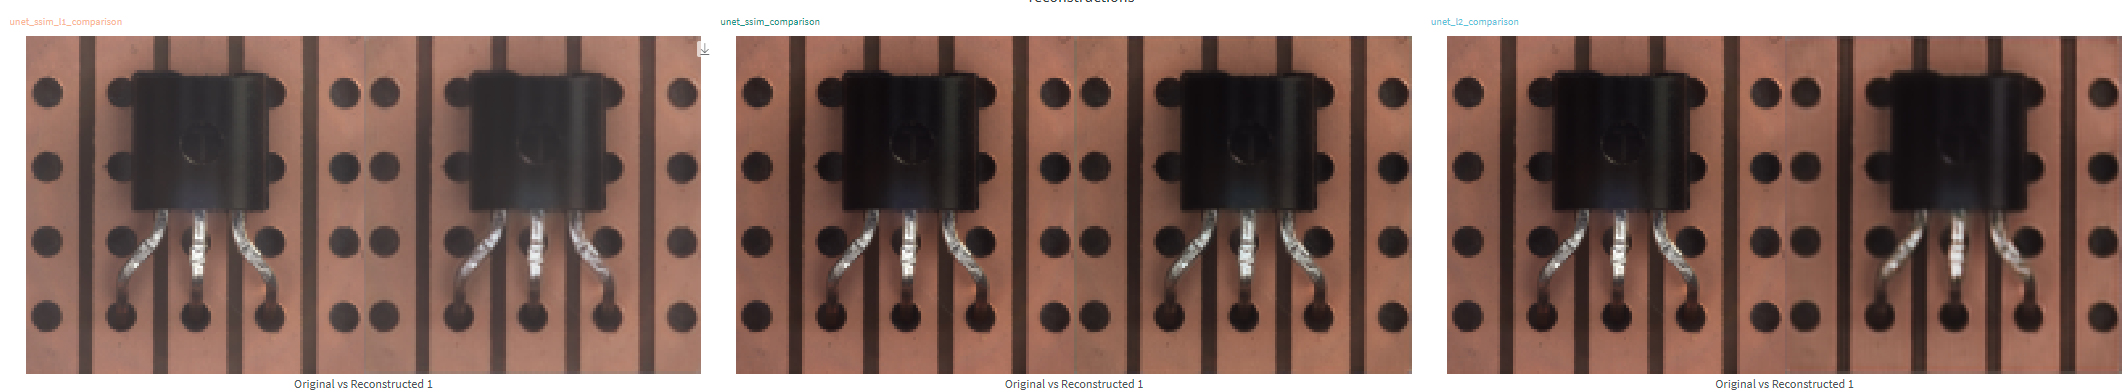

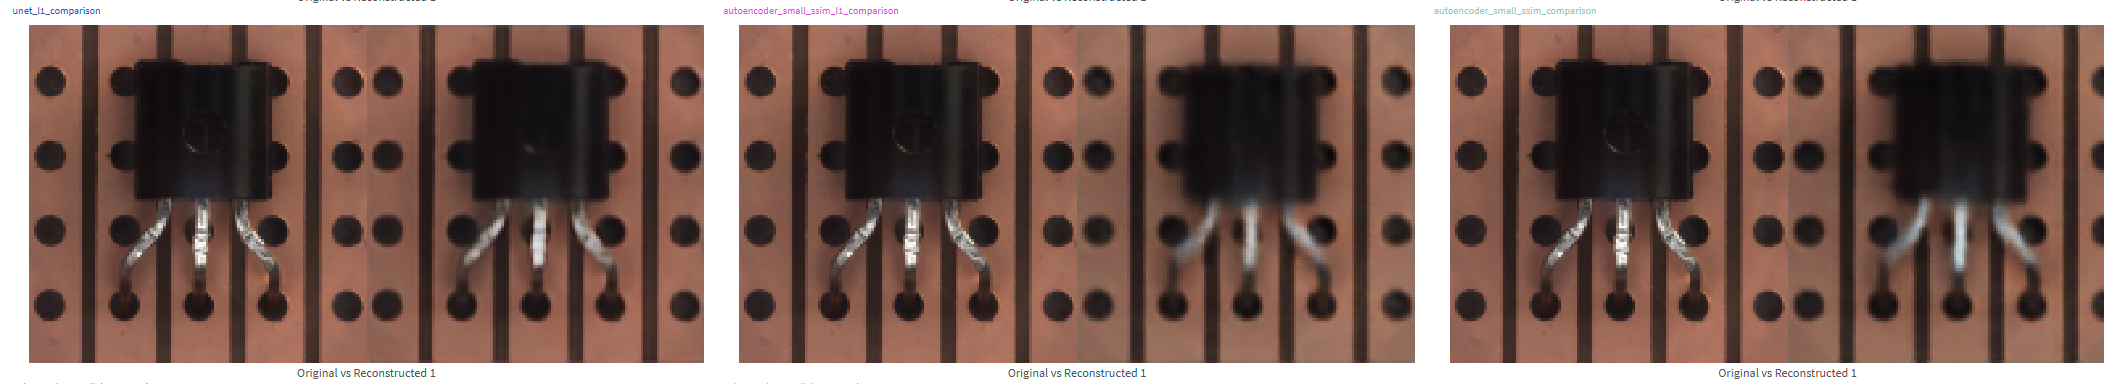

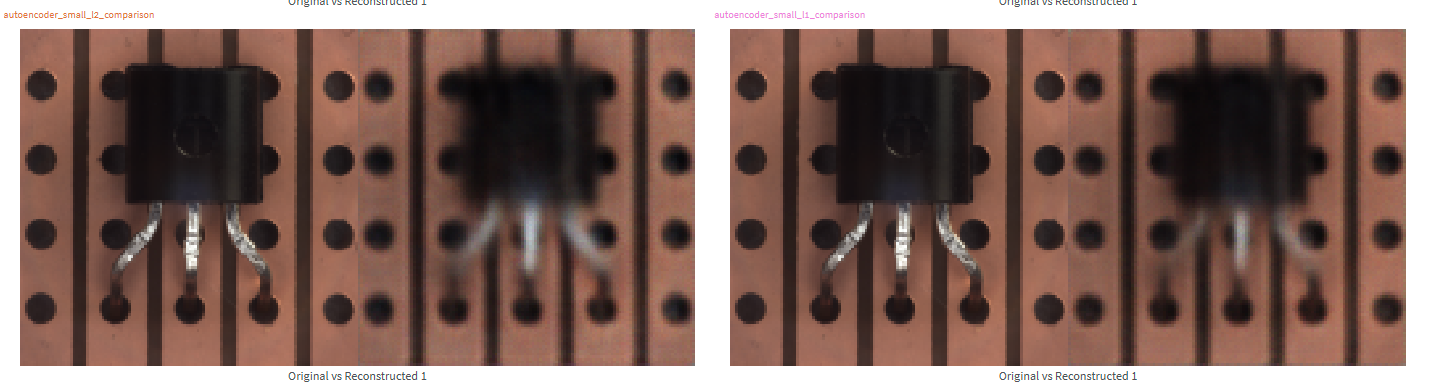

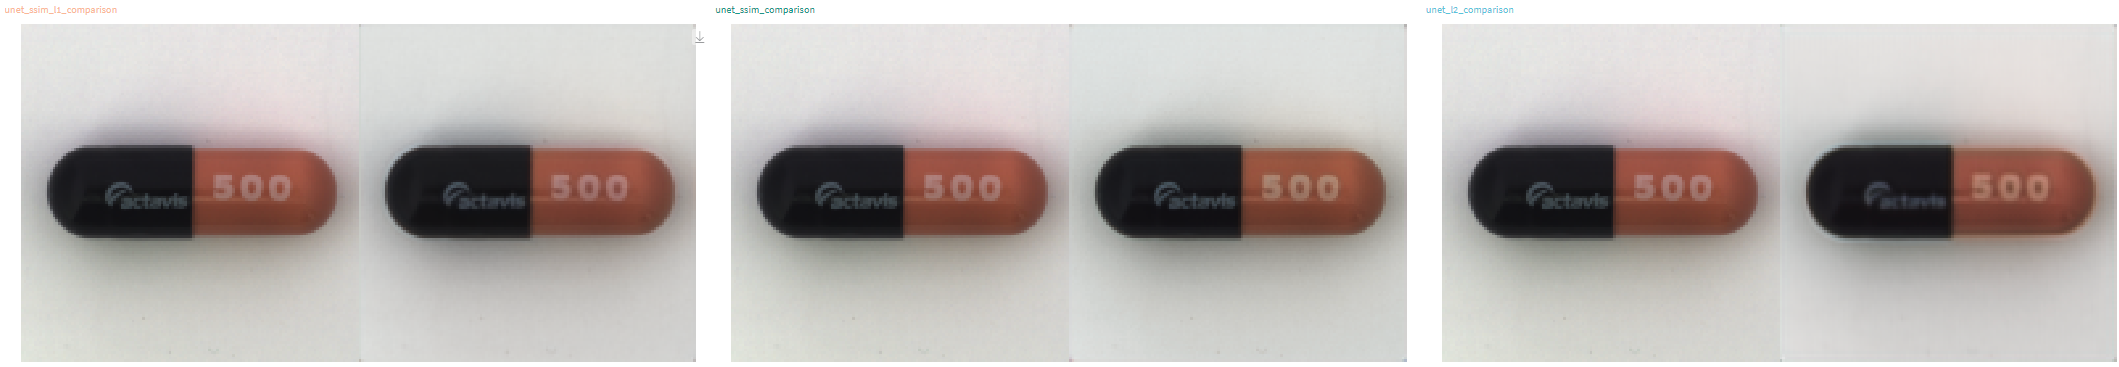

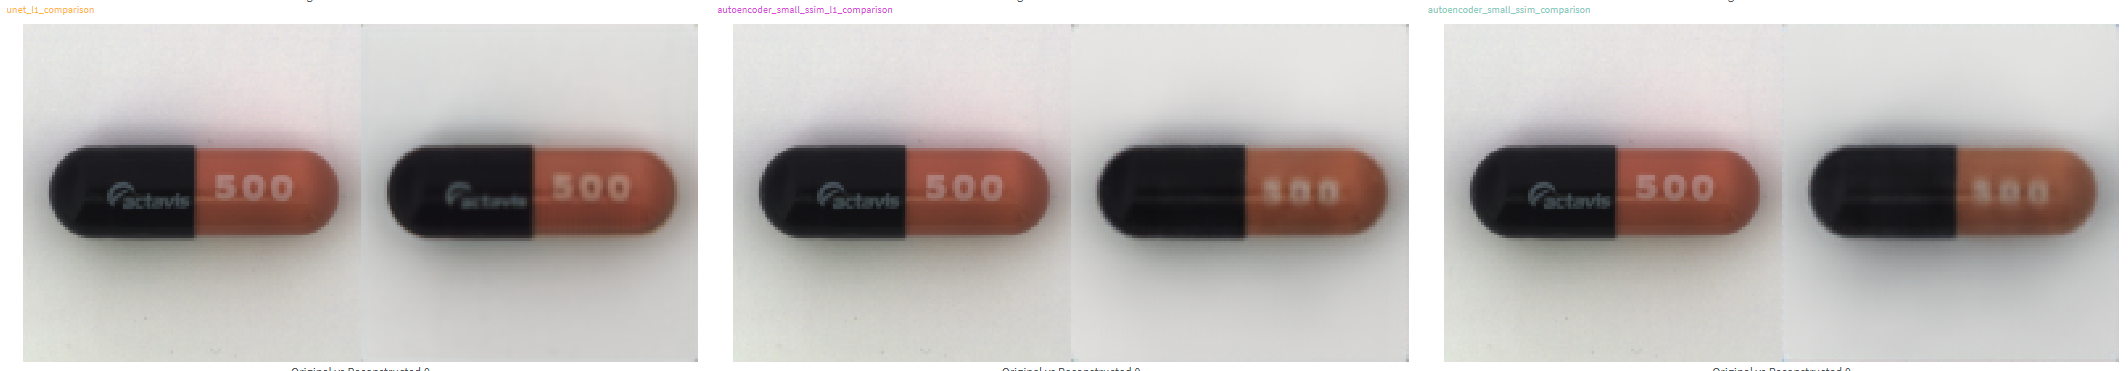

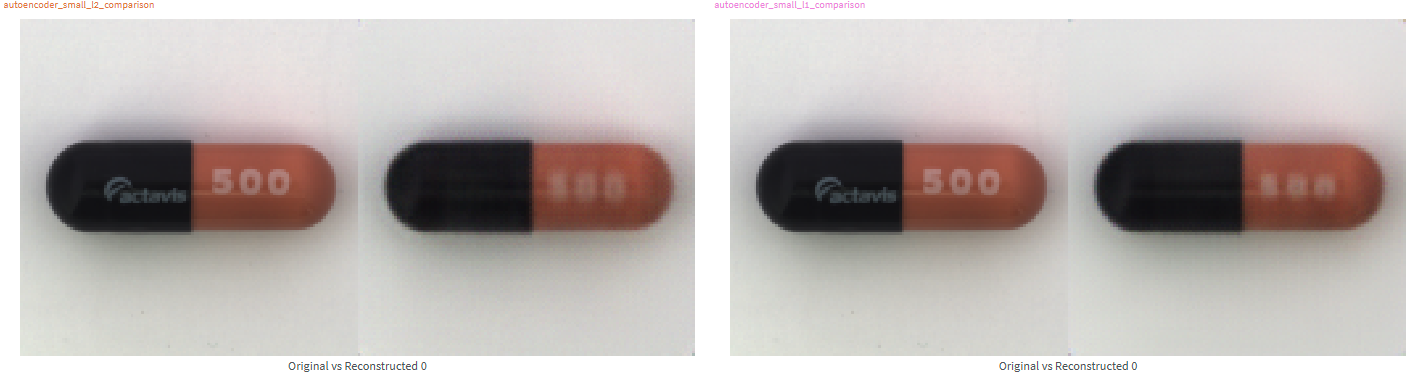

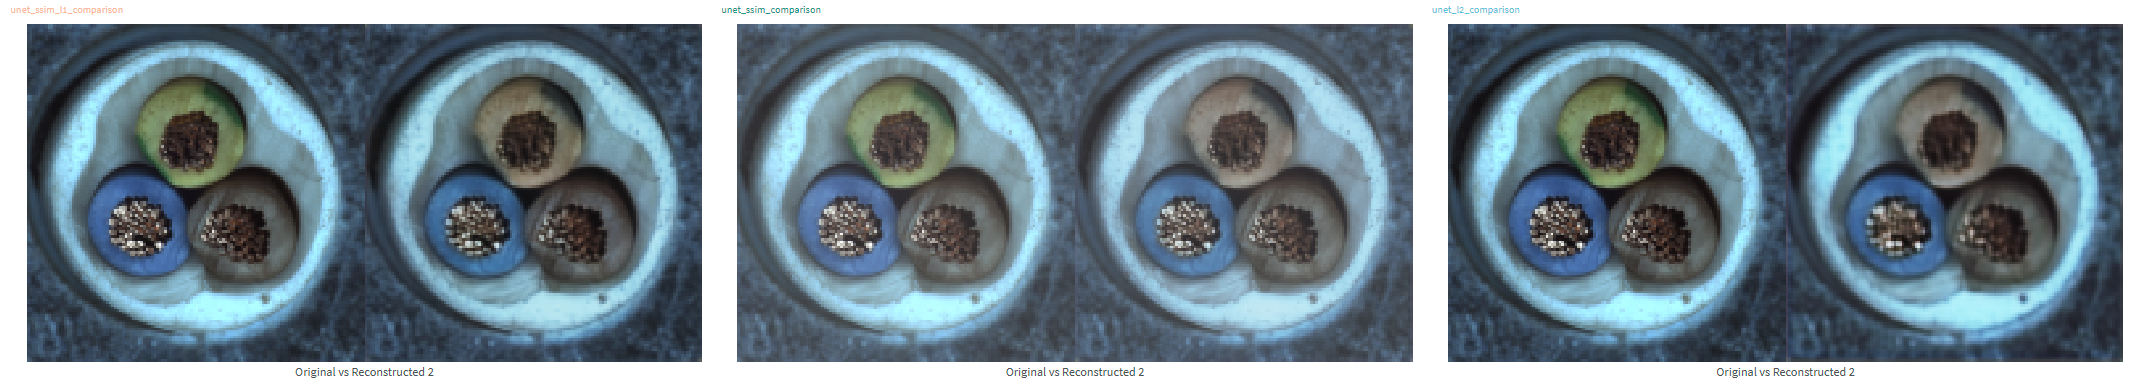

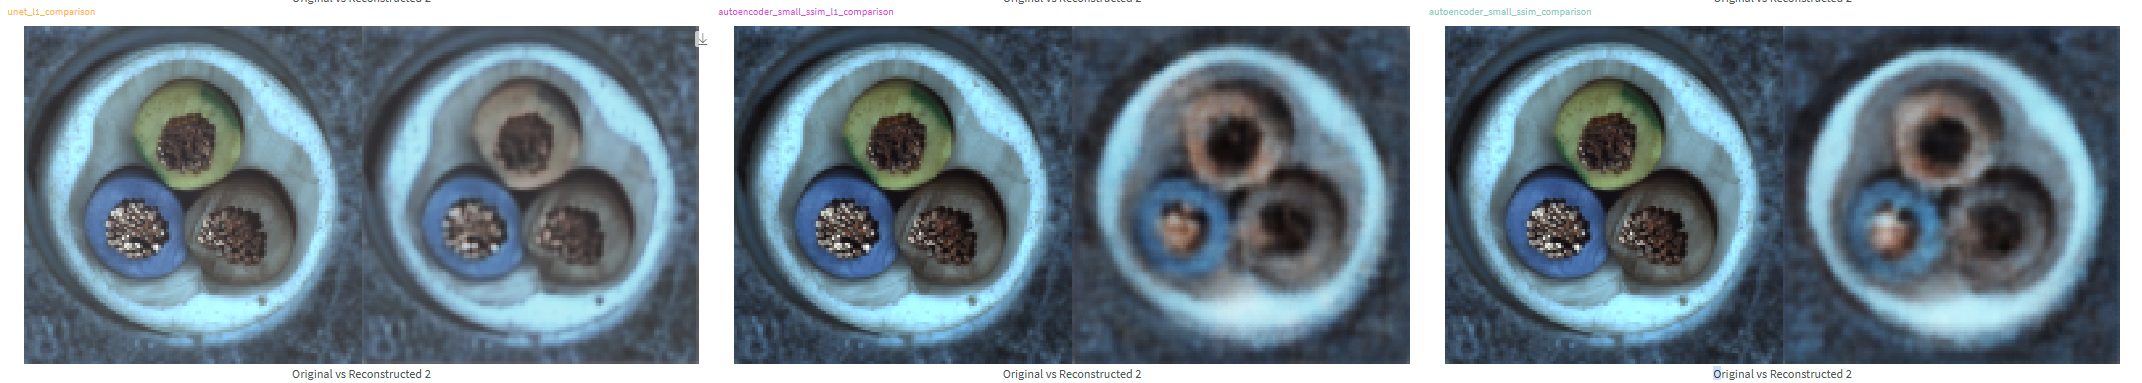

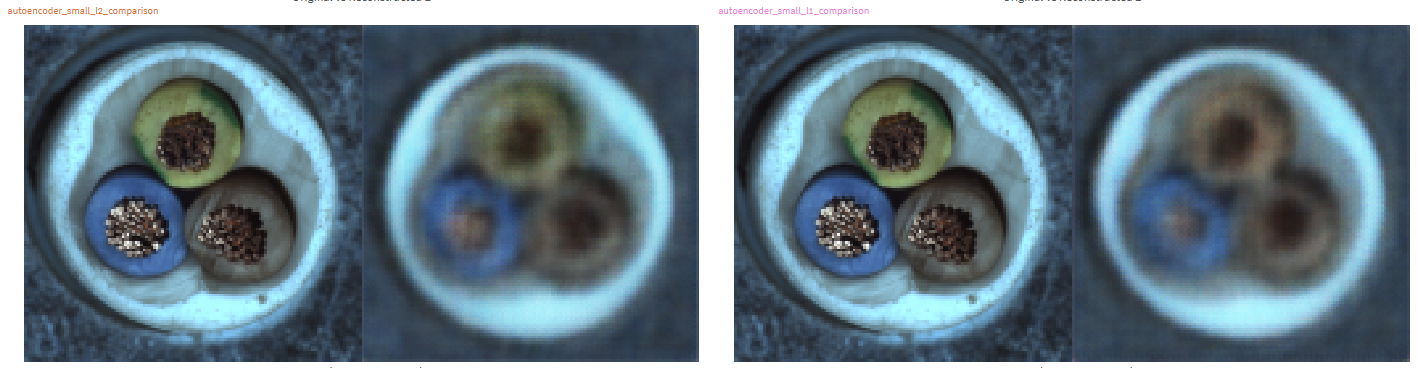

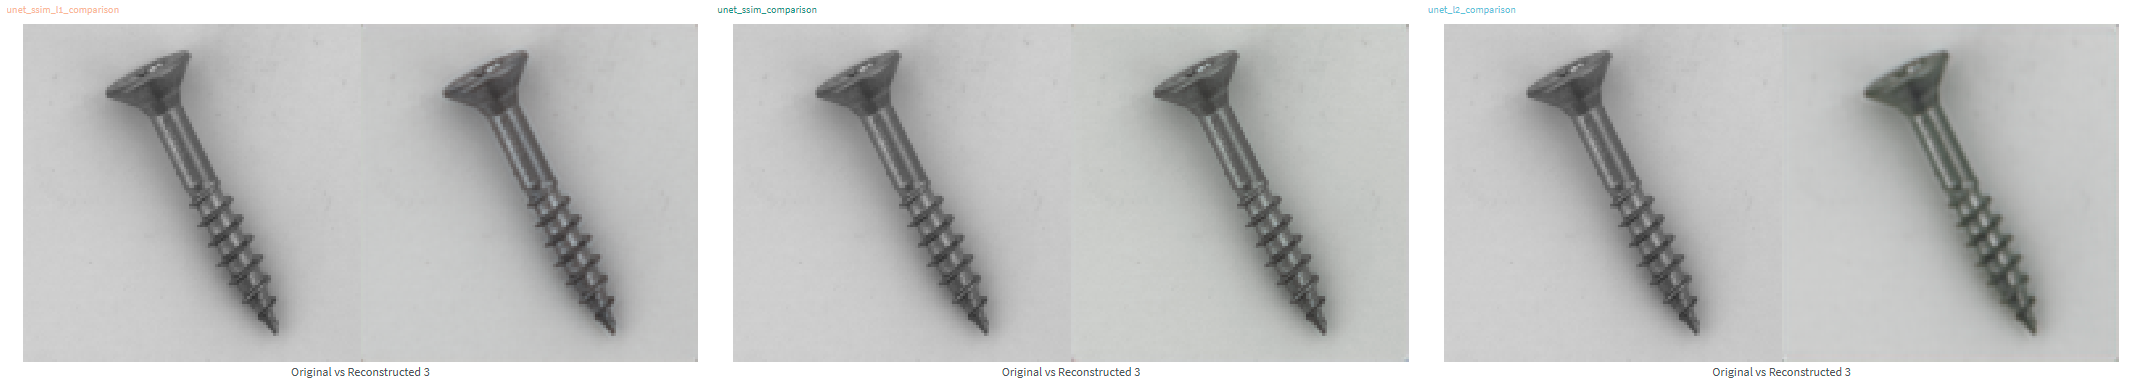

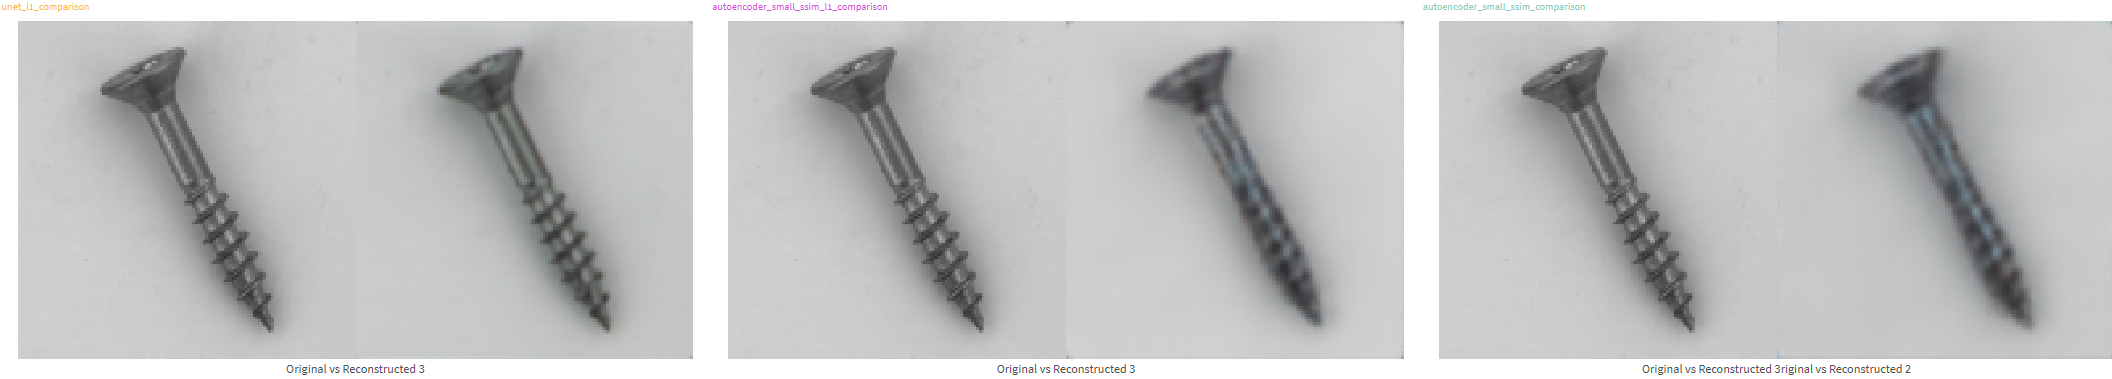

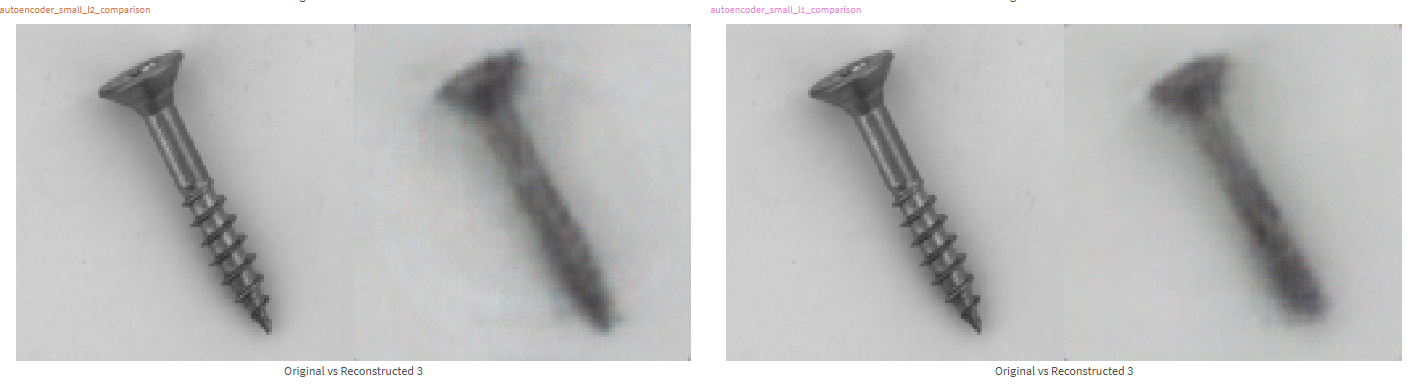